# Snake Game

This project successfully demonstrates the application of Deep Q-Learning (DQN) to train an autonomous agent to play the classic Snake game. By implementing a neural network-based reinforcement learning approach with experience replay and epsilon-greedy exploration, the agent learns to navigate the game environment, avoid collisions, and maximize its score through trial and error. The visualization tools developed for this project, including real-time matplotlib rendering compatible with cloud-based development environments like GitHub Codespaces, make the learning process transparent and accessible for educational purposes. 

**Deep Q-Learning (DQN)**:
Deep Q-Learning extends classical Q-Learning by using Deep Neural Networks to approximate the Q-function, which predicts the "quality" or expected cumulative reward of taking a particular action in a given state. Traditional
Q-Learning uses tables to store Q-values for each state-action pair, which becomes infeasible for environments with large or continuous state spaces.

**Key Innovations in DQN**:

  • Deep Neural Networks: Replace Q-tables with neural networks that can generalize across similar states and handle high-dimensional inputs

  • Experience Replay: Store past experiences (state, action, reward, next_state) in a replay buffer and sample random mini-batches for training, breaking temporal correlations and improving stability

  • Target Network: Maintain a separate, slowly-updating target network to compute Q-value targets, reducing oscillations and improving convergence  

  • Epsilon-Greedy Exploration: Balance exploration (trying new actions) and exploitation (using learned knowledge) through a decaying epsilon parameter


In [ ]:
# Comment out if not needed
%pip install -r requirements.txt

### 1: Install and Import Dependencies

In [ ]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Suppress pygame warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='pygame.pkgdata')

# Set matplotlib for notebook display
plt.style.use('seaborn-v0_8-darkgrid')

/usr/local/python/3.12.1/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


###  Global Variables

In [3]:
# Number of Games to Play for Training
MAX_GAMES = 250 # For powerful systems use 500 for better accuracy 

# Adjust visualize_every based on your needs:
REFRESH = 10
# - visualize_every=1  for smooth animation (slower)
# - visualize_every=10 for faster training with less frequent updates

### 2: Snake Game Class 

In [ ]:

pygame.init()

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

BLOCK_SIZE = 20
SPEED = 0  # No delay in headless mode for faster training


class SnakeGame:
    """Snake Game for Reinforcement Learning Training (Headless Mode)"""

    def __init__(self, w=640, h=640, render=False):
        self.w = w
        self.h = h
        self.render = render  # Set to False for headless mode
        
        # Only create display if rendering
        if self.render:
            if not pygame.get_init():
                pygame.init()
            self.display = pygame.display.set_mode((self.w, self.h))
            pygame.display.set_caption('🐍 Snake RL Training')
            self.clock = pygame.time.Clock()
        else:
            # Headless mode - no display
            self.display = None
            self.clock = None
        
        self.highscore = 0
        self.episode = 0
        self.reset()

    def reset(self):
        """Reset the game state for a new episode"""
        self.episode += 1
        self.direction = Direction.RIGHT
        self.head = Point(self.w/2, self.h/2)
        self.snake = [self.head,
                      Point(self.head.x - BLOCK_SIZE, self.head.y),
                      Point(self.head.x - (2*BLOCK_SIZE), self.head.y)]
        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0

    def _place_food(self):
        """Place food at a random location not occupied by the snake"""
        while True:
            x = random.randint(0, (self.w - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
            y = random.randint(0, (self.h - BLOCK_SIZE) // BLOCK_SIZE) * BLOCK_SIZE
            self.food = Point(x, y)
            if self.food not in self.snake:
                break

    def play_step(self, action):
        """Execute one game step with the given action"""
        self.frame_iteration += 1
        
        # Check for quit events only if rendering
        if self.render:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
        
        # Move snake based on action
        self._move(action)
        self.snake.insert(0, self.head)
        
        # Check if game over
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100 * len(self.snake):
            game_over = True
            reward = -10
            return reward, game_over, self.score
        
        # Place new food or just move
        if self.head == self.food:
            self.score += 1
            if self.score > self.highscore:
                self.highscore = self.score
            
            if self.score > self.highscore * 0.90:
                reward = 100
            elif self.score > self.highscore * 0.50:
                reward = 50
            else:
                reward = 10
            
            self._place_food()
        else:
            self.snake.pop()
        
        # Update UI only if rendering
        if self.render:
            self._update_ui()
            if self.clock:
                self.clock.tick(SPEED)
        
        return reward, game_over, self.score

    def is_collision(self, pt=None):
        """Check if point collides with boundaries or snake body"""
        if pt is None:
            pt = self.head
        if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
            return True
        if pt in self.snake[1:]:
            return True
        return False

    def _update_ui(self):
        """Render the current game state (only if rendering enabled)"""
        if not self.render or self.display is None:
            return
        
        # Modern colors
        BACKGROUND = (20, 20, 35)
        GRID_COLOR = (30, 30, 50)
        SNAKE_HEAD = (100, 255, 150)
        SNAKE_BODY = (60, 200, 100)
        FOOD_COLOR = (255, 80, 80)
        TEXT_COLOR = (220, 220, 240)
        SCORE_COLOR = (100, 255, 150)
        
        self.display.fill(BACKGROUND)
        
        # Draw snake
        for i, pt in enumerate(self.snake):
            color = SNAKE_HEAD if i == 0 else SNAKE_BODY
            pygame.draw.rect(self.display, color, 
                           pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE), 
                           border_radius=5 if i == 0 else 3)
        
        # Draw food
        pygame.draw.rect(self.display, FOOD_COLOR, 
                        pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE), 
                        border_radius=10)
        
        # Draw text
        try:
            font = pygame.font.SysFont('arial', 25)
            text = font.render(f"Score: {self.score}  Best: {self.highscore}  Episode: {self.episode}", 
                             True, SCORE_COLOR)
            self.display.blit(text, [10, 10])
        except:
            pass
        
        pygame.display.flip()

    def _move(self, action):
        """Update snake direction based on action and move head"""
        clock_wise = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        idx = clock_wise.index(self.direction)
        
        if np.array_equal(action, [1, 0, 0]):
            new_dir = clock_wise[idx]
        elif np.array_equal(action, [0, 1, 0]):
            next_idx = (idx + 1) % 4
            new_dir = clock_wise[next_idx]
        else:
            next_idx = (idx - 1) % 4
            new_dir = clock_wise[next_idx]
        
        self.direction = new_dir
        
        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE
        
        self.head = Point(x, y)

    def get_state(self):
        """Get current game state for RL agent"""
        head = self.snake[0]
        point_l = Point(head.x - BLOCK_SIZE, head.y)
        point_r = Point(head.x + BLOCK_SIZE, head.y)
        point_u = Point(head.x, head.y - BLOCK_SIZE)
        point_d = Point(head.x, head.y + BLOCK_SIZE)
        
        dir_l = self.direction == Direction.LEFT
        dir_r = self.direction == Direction.RIGHT
        dir_u = self.direction == Direction.UP
        dir_d = self.direction == Direction.DOWN
        
        state = [
            (dir_r and self.is_collision(point_r)) or 
            (dir_l and self.is_collision(point_l)) or 
            (dir_u and self.is_collision(point_u)) or 
            (dir_d and self.is_collision(point_d)),
            
            (dir_u and self.is_collision(point_r)) or 
            (dir_d and self.is_collision(point_l)) or 
            (dir_l and self.is_collision(point_u)) or 
            (dir_r and self.is_collision(point_d)),
            
            (dir_d and self.is_collision(point_r)) or 
            (dir_u and self.is_collision(point_l)) or 
            (dir_r and self.is_collision(point_u)) or 
            (dir_l and self.is_collision(point_d)),
            
            dir_l, dir_r, dir_u, dir_d,
            
            self.food.x < head.x,
            self.food.x > head.x,
            self.food.y < head.y,
            self.food.y > head.y
        ]
        
        return np.array(state, dtype=int)


print("✅ SnakeGame class loaded (headless mode compatible)!")

✅ SnakeGame class loaded (headless mode compatible)!


### 3: Simple Random Agent (for testing)

In [ ]:

def test_random_agent(num_games=5):
    """
    Test the game with a random agent
    This helps verify the game works correctly
    """
    game = SnakeGame()
    scores = []
    
    for game_num in range(num_games):
        game.reset()
        game_over = False
        total_reward = 0
        
        print(f"\n🎮 Game {game_num + 1}/{num_games}")
        
        while not game_over:
            # Random action: [straight, right, left]
            action = [0, 0, 0]
            action[random.randint(0, 2)] = 1
            
            reward, game_over, score = game.play_step(action)
            total_reward += reward
        
        scores.append(score)
        print(f"   Score: {score} | Total Reward: {total_reward}")
    
    pygame.quit()
    
    print(f"\n📊 Results:")
    print(f"   Average Score: {np.mean(scores):.2f}")
    print(f"   Best Score: {max(scores)}")
    print(f"   Worst Score: {min(scores)}")
    
    return scores

### 4: Real-time plotting for training metrics and game visualization"

In [ ]:

class TrainingPlotter:
    """Real-time plotting for training metrics and game visualization"""
    
    def __init__(self, show_game=True):
        self.scores = []
        self.mean_scores = []
        self.episodes = []
        self.show_game = show_game
        
        if show_game:
            # Create figure with game visualization + metrics
            self.fig = plt.figure(figsize=(18, 5))
            self.ax_game = self.fig.add_subplot(131)
            self.ax_progress = self.fig.add_subplot(132)
            self.ax_recent = self.fig.add_subplot(133)
        else:
            # Just metrics
            self.fig, (self.ax_progress, self.ax_recent) = plt.subplots(1, 2, figsize=(14, 4))
            self.ax_game = None
        
    def visualize_game(self, game):
        """Visualize current game state using matplotlib"""
        if not self.show_game or self.ax_game is None:
            return
        
        self.ax_game.clear()
        
        # Create grid
        grid = np.zeros((game.h // BLOCK_SIZE, game.w // BLOCK_SIZE, 3))
        
        # Draw snake
        for i, pt in enumerate(game.snake):
            x_idx = int(pt.x // BLOCK_SIZE)
            y_idx = int(pt.y // BLOCK_SIZE)
            
            if 0 <= x_idx < grid.shape[1] and 0 <= y_idx < grid.shape[0]:
                if i == 0:  # Head - bright green
                    grid[y_idx, x_idx] = [0.39, 1.0, 0.59]
                else:  # Body - darker green with gradient
                    intensity = 0.4 + (0.4 * (1 - i / len(game.snake)))
                    grid[y_idx, x_idx] = [0.23 * intensity, 0.78 * intensity, 0.39 * intensity]
        
        # Draw food - bright red
        food_x = int(game.food.x // BLOCK_SIZE)
        food_y = int(game.food.y // BLOCK_SIZE)
        if 0 <= food_x < grid.shape[1] and 0 <= food_y < grid.shape[0]:
            grid[food_y, food_x] = [1.0, 0.31, 0.31]
        
        # Display
        self.ax_game.imshow(grid, interpolation='nearest')
        self.ax_game.set_title(f'🐍 Live Game | Score: {game.score} | Episode: {game.episode}', 
                               fontsize=12, fontweight='bold')
        self.ax_game.axis('off')
        
    def plot(self, episode, score, mean_score, game=None):
        """Update all plots with new data"""
        self.episodes.append(episode)
        self.scores.append(score)
        self.mean_scores.append(mean_score)
        
        # Visualize game state if available
        if game and self.show_game:
            self.visualize_game(game)
        
        # Clear progress plots
        self.ax_progress.clear()
        self.ax_recent.clear()
        
        # Plot 1: Score over episodes
        self.ax_progress.plot(self.episodes, self.scores, color='#64FF96', 
                             linewidth=1, alpha=0.6, label='Score')
        self.ax_progress.plot(self.episodes, self.mean_scores, color='#FFD700', 
                             linewidth=2, label='Mean Score')
        self.ax_progress.set_xlabel('Episode')
        self.ax_progress.set_ylabel('Score')
        self.ax_progress.set_title('Training Progress')
        self.ax_progress.legend()
        self.ax_progress.grid(True, alpha=0.3)
        
        # Plot 2: Recent scores (last 100)
        recent_eps = self.episodes[-100:]
        recent_scores = self.scores[-100:]
        if recent_eps:
            self.ax_recent.plot(recent_eps, recent_scores, color='#64FF96', linewidth=2)
        self.ax_recent.set_xlabel('Episode')
        self.ax_recent.set_ylabel('Score')
        self.ax_recent.set_title('Last 100 Episodes')
        self.ax_recent.grid(True, alpha=0.3)
        
        plt.tight_layout()
        display.clear_output(wait=True)
        display.display(self.fig)


print("✅ TrainingPlotter with game visualization loaded!")

✅ TrainingPlotter with game visualization loaded!


### 5: Run Random Agent Test

In [ ]:

print("🐍 Testing Snake Game with Random Agent...")
print("=" * 50)

# Comment this out if you want to skip testing and go straight to training
scores = test_random_agent(num_games=3)

print("\n✅ Game is ready!")
print("\n💡 Next Steps:")
print("   1. Run Cell 6 to start training with Deep Q-Learning")
print("   2. Watch the game window and training plots")
print("   3. Press Ctrl+C to stop training early")


🐍 Testing Snake Game with Random Agent...

🎮 Game 1/3
   Score: 0 | Total Reward: -10

🎮 Game 2/3
   Score: 0 | Total Reward: -10

🎮 Game 3/3
   Score: 0 | Total Reward: -10

📊 Results:
   Average Score: 0.00
   Best Score: 0
   Worst Score: 0

✅ Game is ready!

💡 Next Steps:
   1. Run Cell 6 to start training with Deep Q-Learning
   2. Watch the game window and training plots
   3. Press Ctrl+C to stop training early


### 6: Deep Neural Network Q-Learning Agent

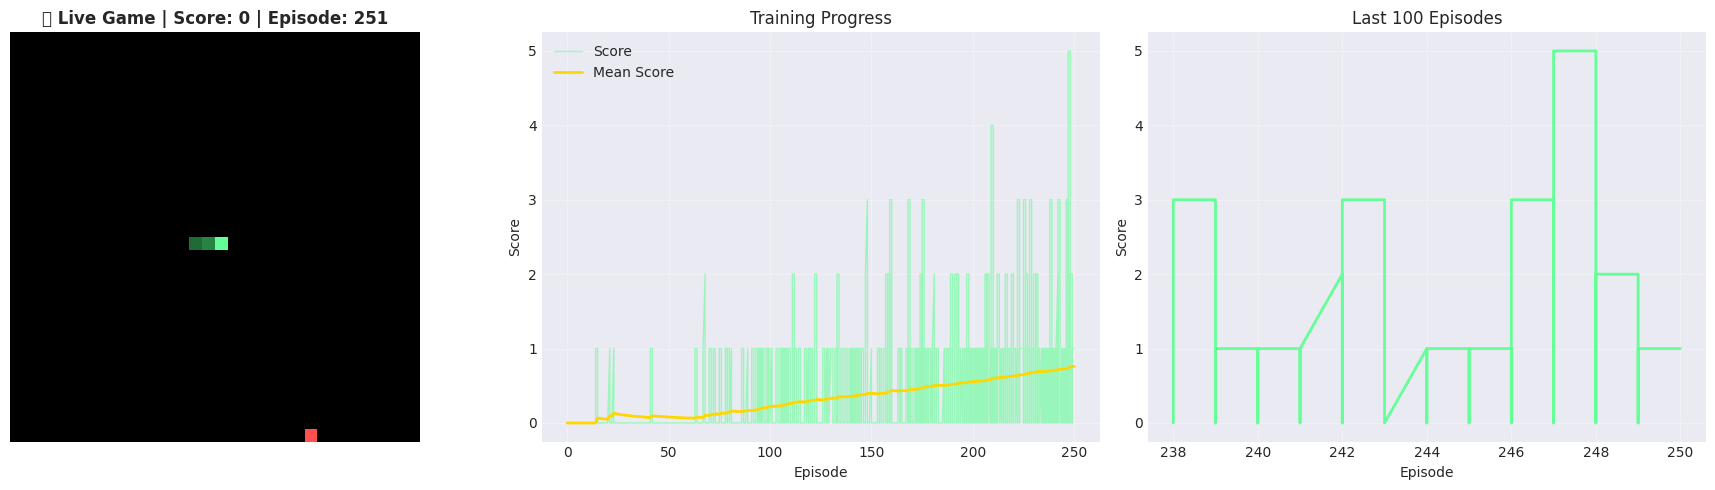

💾 Model saved to checkpoint_250.pth
💾 Model saved to final_model.pth

✅ Training Complete!
   Total Episodes: 250
   Best Score: 5
   Average Score: 0.76
   Final Epsilon: 0.286


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 128013 (\N{SNAKE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


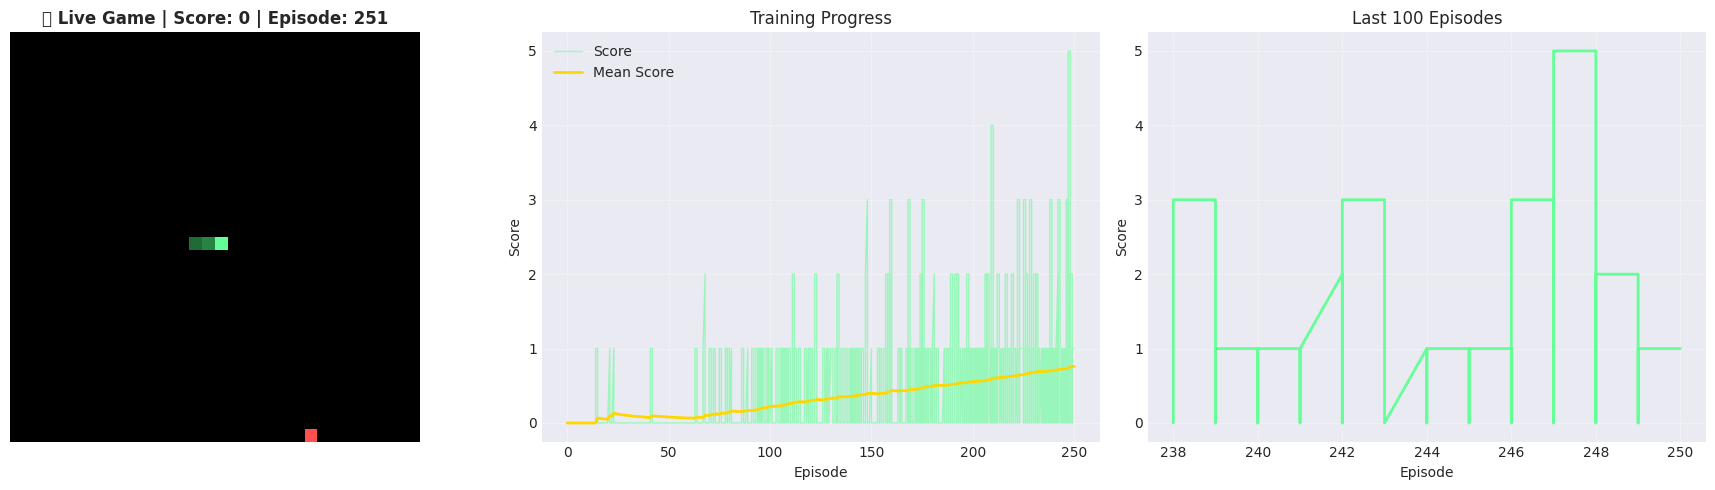

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


class QNetwork(nn.Module):
    """Neural Network for Q-Learning"""
    def __init__(self, input_size=11, hidden_size=256, output_size=3):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class DQNAgent:
    """Deep Q-Network Agent with Experience Replay"""
    def __init__(self, state_size=11, action_size=3, learning_rate=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        
        # Hyperparameters
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = learning_rate
        self.batch_size = 1000
        
        # Neural network
        self.model = QNetwork(state_size, 256, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        self.n_games = 0
        
    def get_action(self, state):
        """Choose action using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            action_idx = random.randint(0, self.action_size - 1)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            with torch.no_grad():
                prediction = self.model(state_tensor)
            action_idx = torch.argmax(prediction).item()
        
        action = [0, 0, 0]
        action[action_idx] = 1
        return action
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def train_step(self, state, action, reward, next_state, done):
        """Train on a single experience"""
        self.remember(state, action, reward, next_state, done)
        
        state_tensor = torch.tensor(state, dtype=torch.float32)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32)
        action_tensor = torch.tensor(action, dtype=torch.long)
        reward_tensor = torch.tensor(reward, dtype=torch.float32)
        
        current_q = self.model(state_tensor)
        
        with torch.no_grad():
            next_q = self.model(next_state_tensor)
            max_next_q = torch.max(next_q)
            
            if done:
                target_q = reward_tensor
            else:
                target_q = reward_tensor + self.gamma * max_next_q
        
        target = current_q.clone()
        action_idx = torch.argmax(action_tensor)
        target[action_idx] = target_q
        
        self.optimizer.zero_grad()
        loss = self.criterion(current_q, target)
        loss.backward()
        self.optimizer.step()
    
    def train_long_memory(self):
        """Train on a batch of experiences from replay memory"""
        if len(self.memory) < self.batch_size:
            mini_batch = self.memory
        else:
            mini_batch = random.sample(self.memory, self.batch_size)
        
        states, actions, rewards, next_states, dones = zip(*mini_batch)
        
        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.long)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.bool)
        
        current_q_values = self.model(states)
        
        with torch.no_grad():
            next_q_values = self.model(next_states)
            max_next_q_values = torch.max(next_q_values, dim=1)[0]
        
        target_q_values = current_q_values.clone()
        for idx in range(len(mini_batch)):
            action_idx = torch.argmax(actions[idx])
            if dones[idx]:
                target_q_values[idx][action_idx] = rewards[idx]
            else:
                target_q_values[idx][action_idx] = rewards[idx] + self.gamma * max_next_q_values[idx]
        
        self.optimizer.zero_grad()
        loss = self.criterion(current_q_values, target_q_values)
        loss.backward()
        self.optimizer.step()
    
    def save(self, filename='model.pth'):
        """Save the model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'n_games': self.n_games
        }, filename)
        print(f"💾 Model saved to {filename}")
    
    def load(self, filename='model.pth'):
        """Load a saved model"""
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.n_games = checkpoint['n_games']
        print(f"📂 Model loaded from {filename}")


def train(max_games=500, render=False, visualize_every=1):
    """
    Main training loop for the DQN agent
    
    Args:
        max_games: Maximum number of episodes to train
        render: Set to True to show game window (only works with display)
        visualize_every: Update matplotlib visualization every N steps (1=every step, 10=every 10 steps)
    """
    print("🚀 Starting Deep Q-Learning Training")
    print("=" * 60)
    print(f"Max Episodes: {max_games}")
    print(f"Render Mode: {'Visual' if render else 'Headless (faster)'}")
    print(f"Matplotlib Visualization: Every {visualize_every} step(s)")
    print(f"State Size: 11")
    print(f"Action Size: 3")
    print("=" * 60)
    
    plotter = TrainingPlotter(show_game=True)  # Enable game visualization
    game = SnakeGame(render=render)
    agent = DQNAgent(state_size=11, action_size=3)
    
    total_score = 0
    record = 0
    n_games = 0
    step_count = 0
    
    try:
        while n_games < max_games:
            state_old = game.get_state()
            action = agent.get_action(state_old)
            reward, game_over, score = game.play_step(action)
            state_new = game.get_state()
            agent.train_step(state_old, action, reward, state_new, game_over)
            
            # Update visualization periodically during gameplay
            step_count += 1
            if step_count % visualize_every == 0:
                mean_score = total_score / max(n_games, 1)
                plotter.plot(n_games, score, mean_score, game=game)
            
            if game_over:
                game.reset()
                n_games += 1
                agent.n_games = n_games
                agent.train_long_memory()
                
                if agent.epsilon > agent.epsilon_min:
                    agent.epsilon *= agent.epsilon_decay
                
                if score > record:
                    record = score
                    agent.save('best_model.pth')
                
                total_score += score
                mean_score = total_score / n_games
                
                print(f'Episode: {n_games:4d} | Score: {score:3d} | Record: {record:3d} | '
                      f'Mean: {mean_score:.2f} | Epsilon: {agent.epsilon:.3f}')
                
                # Always update plot at end of episode
                plotter.plot(n_games, score, mean_score, game=game)
                
                if n_games % 50 == 0:
                    agent.save(f'checkpoint_{n_games}.pth')
    
    except KeyboardInterrupt:
        print("\n⚠️  Training interrupted by user")
    
    except Exception as e:
        print(f"\n❌ Error during training: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        try:
            pygame.quit()
        except:
            pass
        
        if n_games > 0:
            agent.save('final_model.pth')
            print(f"\n✅ Training Complete!")
            print(f"   Total Episodes: {n_games}")
            print(f"   Best Score: {record}")
            print(f"   Average Score: {total_score/n_games:.2f}")
            print(f"   Final Epsilon: {agent.epsilon:.3f}")
        else:
            print("\n⚠️  No games completed")


def play_with_trained_model(model_path='best_model.pth', num_games=5, visualize_every=5):
    """
    Watch a trained agent play with matplotlib visualization
    
    Args:
        model_path: Path to saved model
        num_games: Number of games to play
        visualize_every: Update visualization every N steps
    """
    print(f"\n🎮 Playing with trained model: {model_path}")
    print("=" * 60)
    
    game = SnakeGame(render=False)
    agent = DQNAgent(state_size=11, action_size=3)
    
    try:
        agent.load(model_path)
        agent.epsilon = 0  # No exploration, only exploitation
    except FileNotFoundError:
        print(f"❌ Model file not found: {model_path}")
        print("   Please train the model first!")
        return
    
    # Create figure for game visualization
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.ion()  # Turn on interactive mode
    
    scores = []
    
    for game_num in range(num_games):
        game.reset()
        game_over = False
        step_count = 0
        
        print(f"\n🎯 Game {game_num + 1}/{num_games}")
        
        while not game_over:
            state = game.get_state()
            action = agent.get_action(state)
            reward, game_over, score = game.play_step(action)
            
            # Visualize gameplay
            step_count += 1
            if step_count % visualize_every == 0 or game_over:
                ax.clear()
                
                # Create grid
                grid = np.zeros((game.h // BLOCK_SIZE, game.w // BLOCK_SIZE, 3))
                
                # Draw snake
                for i, pt in enumerate(game.snake):
                    x_idx = int(pt.x // BLOCK_SIZE)
                    y_idx = int(pt.y // BLOCK_SIZE)
                    
                    if 0 <= x_idx < grid.shape[1] and 0 <= y_idx < grid.shape[0]:
                        if i == 0:  # Head
                            grid[y_idx, x_idx] = [0.39, 1.0, 0.59]
                        else:  # Body
                            intensity = 0.4 + (0.4 * (1 - i / len(game.snake)))
                            grid[y_idx, x_idx] = [0.23 * intensity, 0.78 * intensity, 0.39 * intensity]
                
                # Draw food
                food_x = int(game.food.x // BLOCK_SIZE)
                food_y = int(game.food.y // BLOCK_SIZE)
                if 0 <= food_x < grid.shape[1] and 0 <= food_y < grid.shape[0]:
                    grid[food_y, food_x] = [1.0, 0.31, 0.31]
                
                ax.imshow(grid, interpolation='nearest')
                ax.set_title(f'🎮 Game {game_num + 1}/{num_games} | Score: {score} | Step: {step_count}', 
                           fontsize=14, fontweight='bold')
                ax.axis('off')
                
                display.clear_output(wait=True)
                display.display(fig)
                plt.pause(0.001)  # Small pause to update display
        
        scores.append(score)
        print(f"   Final Score: {score}")
    
    plt.ioff()  # Turn off interactive mode
    plt.close()
    
    print(f"\n📊 Results:")
    print(f"   Average Score: {np.mean(scores):.2f}")
    print(f"   Best Score: {max(scores)}")
    print(f"   Worst Score: {min(scores)}")


# ============================================================================
# START TRAINING
# ============================================================================

print("\n" + "="*60)
print("🐍 DEEP Q-LEARNING SNAKE AI")
print("="*60)
print("\n📚 What will happen:")
print("   • The game window will open")
print("   • AI will start learning to play Snake")
print("   • Training plots will update in real-time")
print("   • Best model saves automatically")
print("   • Press Ctrl+C to stop early")
print("\n" + "="*60 + "\n")

# ============================================================================
# START TRAINING WITH LIVE GAME VISUALIZATION
# ============================================================================

print("\n" + "="*60)
print("🐍 DEEP Q-LEARNING SNAKE AI WITH LIVE VISUALIZATION")
print("="*60)
print("\n📺 You will see:")
print("   • LEFT: Live game state (snake in green, food in red)")
print("   • MIDDLE: Training progress over all episodes")
print("   • RIGHT: Recent performance (last 100 episodes)")
print("\n⚙️ Performance Tips:")
print("   • visualize_every=1  → Update every step (slower, smooth)")
print("   • visualize_every=5  → Update every 5 steps (faster)")
print("   • visualize_every=10 → Update every 10 steps (fastest)")
print("\n💡 Press Ctrl+C to stop training early")
print("\n" + "="*60 + "\n")

# Run training with live visualization

train(max_games=MAX_GAMES, render=False, visualize_every=REFRESH)

# After training completes, watch your trained AI play:


### After training completes, watch the trained AI play:

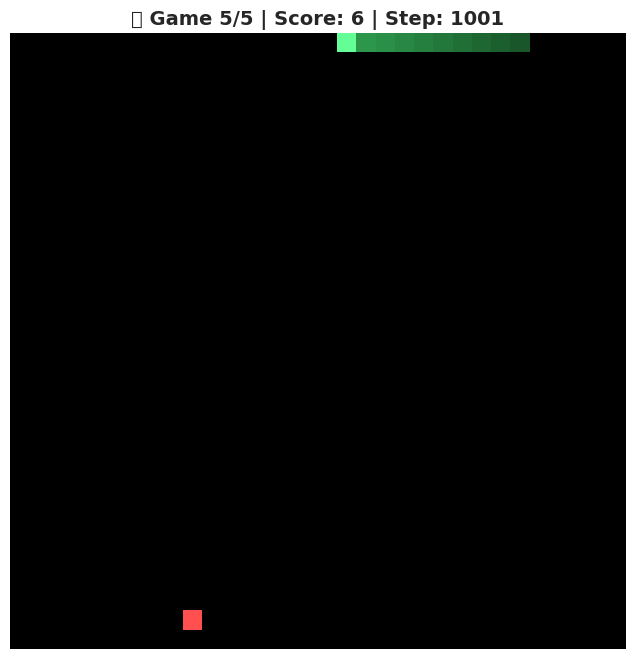

   Final Score: 6

📊 Results:
   Average Score: 19.60
   Best Score: 61
   Worst Score: 5


In [9]:

play_with_trained_model('best_model.pth', num_games=5, visualize_every=5)

## Conclusion


Through hyperparameter tuning—including the discount factor (γ=0.9), learning rate (0.001), and epsilon decay (0.995)—the agent progressively improves its performance over hundreds of episodes, transitioning from random exploration to strategic exploitation of learned policies. This implementation serves as a practical introduction to key reinforcement learning concepts including state representation, reward shaping, temporal difference learning, and the balance between exploration and exploitation. The modular, well-documented code structure allows students to experiment with different RL algorithms, modify reward structures, and observe how various design choices impact learning performance, making it an effective teaching tool for understanding the fundamentals of artificial intelligence and machine learning in interactive environments.